In [90]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns

from utils.load_data import load_data
from utils.preprocessing import preprocess_data
from models.BaseModel import BaseModel
from models.KFModel import KFModel

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
SEED = 0
EPS = 1e-6
TRAIN_PROPORTION = 0.9
TAKE_GDP_DELTA = True

In [92]:
data = load_data()

X, y, countries, y_mean, y_std = preprocess_data(data=data, epsilon=EPS, take_gdp_diff=TAKE_GDP_DELTA, past_gdp_lag=None)

X

,date,Expense_average,Research_and_development_average,Capital_expenditure_average,Business_average,Cost_average,Tax_average,Financial_capital_average,Investment_average,Gross_domestic_product_average,...,Artificial_intelligence_average,International_Financial_Reporting_Standards_average,Employment_average,country_Canada,country_Germany,country_Japan,country_Korea,country_Switzerland,country_United Kingdom,country_United States
6646,-1.777831,-0.038086,3.258700,0.587798,1.659068,-0.683055,1.397999,0.081122,1.701575,0.762734,...,-0.453984,-0.602676,1.695373,-0.412631,-0.415645,-0.366131,-0.412631,-0.415645,-0.415645,2.401504
6173,-1.777831,-1.011806,2.774718,-1.702307,1.724166,-1.038012,-0.772912,1.071828,2.591679,2.275214,...,-0.278382,0.743868,2.109294,-0.412631,-0.415645,-0.366131,-0.412631,-0.415645,2.401504,-0.415645
3645,-1.777831,-0.448073,2.230239,-1.702307,0.519849,0.635358,0.312543,-0.604751,0.875049,3.787694,...,-0.336916,-1.717057,1.845890,-0.412631,-0.415645,-0.366131,2.419047,-0.415645,-0.415645,-0.415645
5892,-1.777831,2.780575,-2.428085,-1.702307,1.431224,-1.291553,1.325635,-0.604751,2.528100,-3.270546,...,-0.044247,-1.717057,0.905158,-0.412631,-0.415645,-0.366131,-0.412631,2.401504,-0.415645,-0.415645
2348,-1.777831,1.396869,0.717796,0.791363,1.235929,-1.595802,1.820120,-0.604751,1.955890,0.618688,...,-0.395450,0.651003,0.867529,-0.412631,2.401504,-0.366131,-0.412631,-0.415645,-0.415645,-0.415645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856,1.715406,2.114346,-0.359063,1.554731,1.118752,2.004478,3.146788,-0.223710,1.129365,1.699031,...,5.106734,0.418840,0.867529,2.419047,-0.415645,-0.366131,-0.412631,-0.415645,-0.415645,-0.415645
6413,1.715406,-0.140583,1.262275,0.129777,0.780242,1.091731,2.724666,-0.452335,1.574417,3.571625,...,4.755530,-0.277648,1.808260,-0.412631,-0.415645,-0.366131,-0.412631,-0.415645,2.401504,-0.415645
2588,1.715406,0.781888,-0.310665,1.605622,0.259456,2.308727,2.423151,-0.604751,1.637996,0.978802,...,4.814064,-0.463378,-0.863417,-0.412631,2.401504,-0.366131,-0.412631,-0.415645,-0.415645,-0.415645
6132,1.715406,1.806856,-1.399624,1.656514,0.845340,2.359435,3.267394,-0.604751,2.528100,1.987122,...,5.106734,-0.184783,1.469597,-0.412631,-0.415645,-0.366131,-0.412631,2.401504,-0.415645,-0.415645


In [93]:
y

6646    0.533792
6173   -0.658800
3645   -0.582796
5892    1.130145
2348   -0.558347
          ...   
856    -1.604017
6413   -0.074373
2588    0.759077
6132    1.616011
6886   -0.668369
Name: GDP, Length: 549, dtype: float64

In [94]:
number_train = int(len(X) * TRAIN_PROPORTION)

X_train, X_valid  = X.values[:number_train, :], X.values[number_train:, :]
y_train, y_valid = y.values[:number_train], y.values[number_train:]
country_train = countries.values[:number_train]
country_valid = countries.values[number_train:]


In [95]:
model = BaseModel(seed=SEED, n_models=5)

# Fit and predict on training and validation data
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_valid = model.predict(X_valid)

kf_model = KFModel(seed=SEED)

# Fit and predict on training and validation data with Kalman Filter
y_pred_train_kf = kf_model.fit(X_train, y_train, country_train)
y_pred_valid_kf = kf_model.predict(X_valid, country_valid)

Base model :


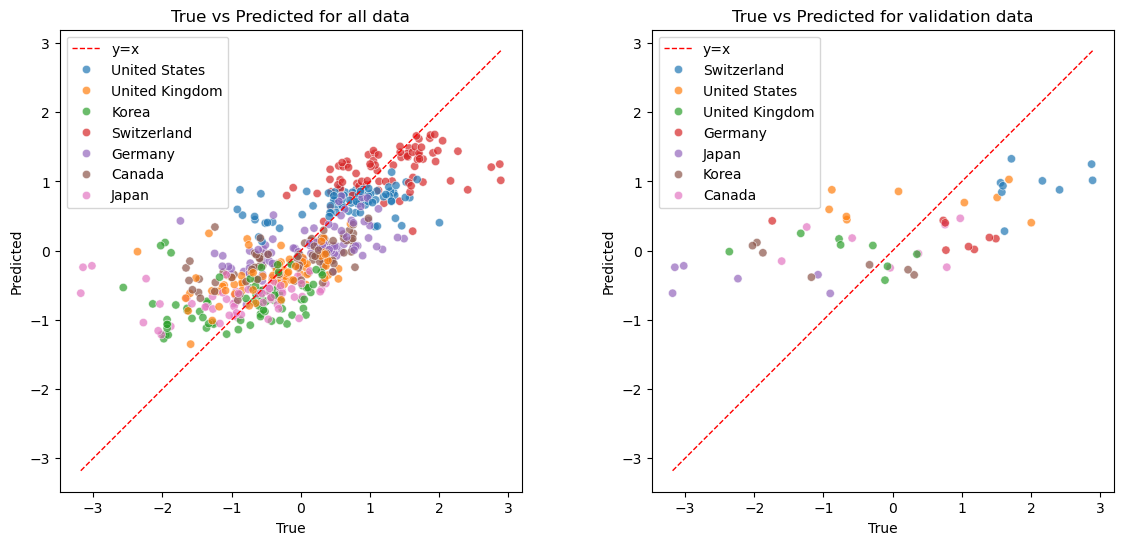

KF model :


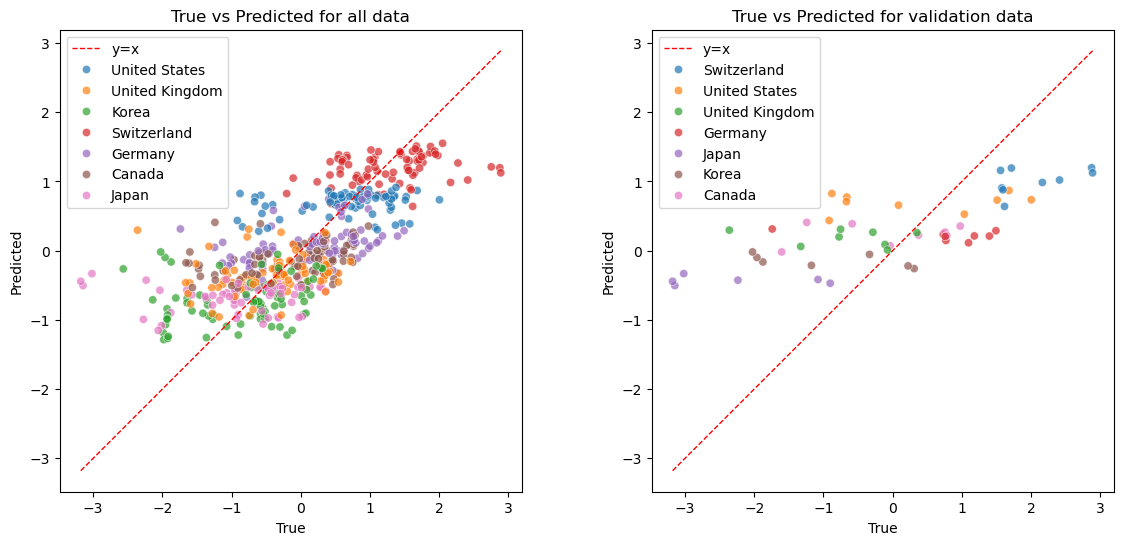

In [96]:
# Associate the result by country
y_pred_valid_country = pd.DataFrame({'date': X['date'][number_train:], 'country': country_valid, 'y_pred': y_pred_valid, 'y_true': y_valid, 'y_pred_kf': y_pred_valid_kf})
y_pred_train_country = pd.DataFrame({'date': X['date'][:number_train], 'country': country_train, 'y_pred': y_pred_train, 'y_true': y_train, 'y_pred_kf': y_pred_train_kf})

# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_valid_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country"], value_vars=["y_pred", "y_true", "y_pred_kf"],
    var_name="Type", value_name="Value"
)

def plot_predictions_against_true(df, true_key="y_true", pred_key="y_pred"):
    plt.figure(figsize=(14, 6))

    ax = plt.subplot(1, 2, 1)
    ax.set_box_aspect(1)

    plt.plot([np.min(predictions[true_key]), np.max(predictions[true_key])], [np.min(predictions[true_key]), np.max(predictions[true_key])], color='red', linewidth=1, linestyle='--', label='y=x')
    sns.scatterplot(x=true_key, y=pred_key, data=predictions, hue='country', alpha=0.7)
    plt.title('True vs Predicted for all data')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.legend()

    ax = plt.subplot(1, 2, 2)
    ax.set_box_aspect(1)

    plt.plot([np.min(y_pred_valid_country[true_key]), np.max(y_pred_valid_country[true_key])], [np.min(y_pred_valid_country[true_key]), np.max(y_pred_valid_country[true_key])], color='red', linewidth=1, linestyle='--', label='y=x')
    sns.scatterplot(x=true_key, y=pred_key, data=y_pred_valid_country, hue='country', alpha=0.7)
    plt.title('True vs Predicted for validation data')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.legend()

    plt.show()

print("Base model :")
plot_predictions_against_true(predictions, true_key="y_true", pred_key="y_pred")

print("KF model :")
plot_predictions_against_true(predictions, true_key="y_true", pred_key="y_pred_kf")

In [97]:
# Calculate Mean Squared Error
print(f"Base model : Training  ME: {mean_squared_error(y_train, y_pred_train):.4f}, Validation MSE: {mean_squared_error(y_valid, y_pred_valid):.4f}")
print(f"  KF model : Training  ME: {mean_squared_error(y_train, y_pred_train_kf):.4f}, Validation MSE: {mean_squared_error(y_valid, y_pred_valid_kf):.4f}")

# Function to plot data with confidence intervals for the selected country
def plot_by_country_with_confidence(selected_country):
    filtered_data = predictions_melted[predictions_melted["country"] == selected_country]
    cutoff_date = filtered_data['date'].quantile(TRAIN_PROPORTION)

    plt.figure(figsize=(12, 6))

    # Plot predictions and true values
    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", style="Type", markers=True, dashes=False
    )

    # Add a vertical line to indicate where validation starts
    plt.axvline(x=cutoff_date, color='red', linestyle='--', label=f'Validation Start ({(TRAIN_PROPORTION)*100:.0f}%)')

    # Enhancing the plot
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the updated plot function
interact(plot_by_country_with_confidence, selected_country=dropdown)

Base model : Training  ME: 0.2509, Validation MSE: 1.7012
  KF model : Training  ME: 0.3231, Validation MSE: 1.6328


interactive(children=(Dropdown(description='Country:', options=('United States', 'United Kingdom', 'Korea', 'S…

<function __main__.plot_by_country_with_confidence(selected_country)>

In [98]:
# OLD

import shap

PLOT_SHAP = False

if PLOT_SHAP:
    explainer = shap.KernelExplainer(model.predict, shap.kmeans(X_train, 20))
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_test)
